Device: cuda


README.md: 0.00B [00:00, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/212M [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/89.1M [00:00<?, ?B/s]

data/train-00000-of-00002.parquet:   0%|          | 0.00/442M [00:00<?, ?B/s]

data/train-00001-of-00002.parquet:   0%|          | 0.00/437M [00:00<?, ?B/s]

Generating test split:   0%|          | 0/3352 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/20210 [00:00<?, ? examples/s]

DatasetDict({
    test: Dataset({
        features: ['image', 'annotation', 'scene_category'],
        num_rows: 3352
    })
    validation: Dataset({
        features: ['image', 'annotation', 'scene_category'],
        num_rows: 2000
    })
    train: Dataset({
        features: ['image', 'annotation', 'scene_category'],
        num_rows: 20210
    })
})


ade20k-id2label.json: 0.00B [00:00, ?B/s]

Number of ADE20K classes: 150
First 10 labels: [(0, 'wall'), (1, 'building'), (2, 'sky'), (3, 'floor'), (4, 'tree'), (5, 'ceiling'), (6, 'road'), (7, 'bed '), (8, 'windowpane'), (9, 'grass')]
Loading SegFormer model: nvidia/segformer-b0-finetuned-ade-512-512


preprocessor_config.json:   0%|          | 0.00/271 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/15.0M [00:00<?, ?B/s]

Number of outside labels: 31
Number of inside-store labels: 119
Saved to: /kaggle/working/store_aisle_detection.mp4


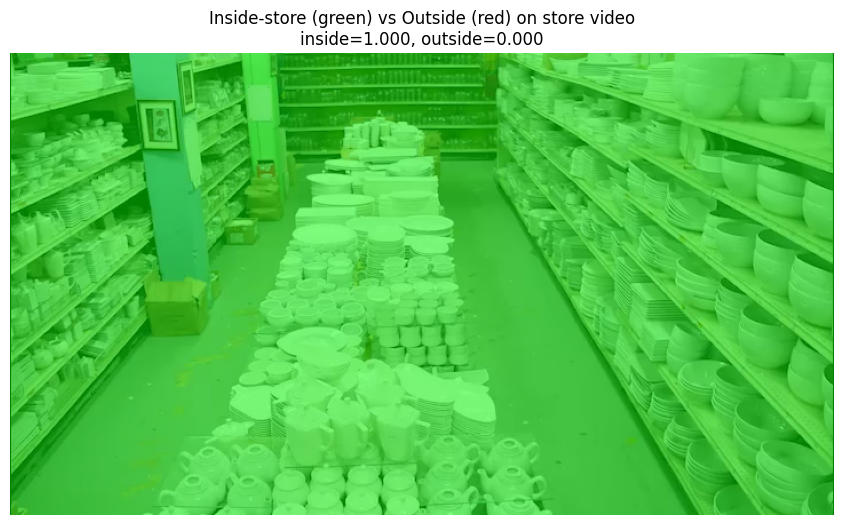

Inside-store pixel ratio: 1.000
Outside pixel ratio:     0.000


In [3]:
import os
import json
from pathlib import Path
import urllib.request

import numpy as np
import torch
import cv2
import matplotlib.pyplot as plt

from datasets import load_dataset
from huggingface_hub import hf_hub_download
from PIL import Image
from transformers import AutoImageProcessor, SegformerForSemanticSegmentation

# --------------------------------------------------------------
# 1. Device
# --------------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# --------------------------------------------------------------
# 2. Download SceneParse150 (ADE20K-based) dataset
#    (train/validation/test are all cached for you)
# --------------------------------------------------------------
print("Downloading SceneParse150 (ADE20K-based) dataset (Parquet copy)...")
# Uses a parquet-based mirror compatible with datasets>=4.x
scene_ds = load_dataset("merve/scene_parse_150")
print(scene_ds)
# --------------------------------------------------------------
# 3. Download ADE20K id2label mapping (class id → class name)
# --------------------------------------------------------------
print("Downloading ADE20K id2label mapping...")
repo_id = "huggingface/label-files"
filename = "ade20k-id2label.json"

id2label = json.loads(
    Path(
        hf_hub_download(repo_id, filename, repo_type="dataset")
    ).read_text()
)
id2label = {int(k): v for k, v in id2label.items()}
label2id = {v: k for k, v in id2label.items()}
num_labels = len(id2label)

print("Number of ADE20K classes:", num_labels)
print("First 10 labels:", list(id2label.items())[:10])

# --------------------------------------------------------------
# 4. Load SegFormer model fine-tuned on ADE20K
# --------------------------------------------------------------
MODEL_CHECKPOINT = "nvidia/segformer-b0-finetuned-ade-512-512"
print("Loading SegFormer model:", MODEL_CHECKPOINT)

image_processor = AutoImageProcessor.from_pretrained(MODEL_CHECKPOINT)
model = SegformerForSemanticSegmentation.from_pretrained(MODEL_CHECKPOINT).to(device)
model.eval()

# --------------------------------------------------------------
# 5. Define mapping from ADE20K classes → outside vs inside-store
# --------------------------------------------------------------
OUTSIDE_KEYWORDS = [
    "sky", "tree", "plant", "grass", "hill", "mountain",
    "sea", "river", "water", "lake", "ocean",
    "road", "highway", "street", "sidewalk", "path",
    "field", "sand", "snow", "rock", "earth", "ground",
    "railroad", "railway", "train", "bus", "truck", "car",
    "boat", "ship", "bridge", "pier", "fence",
    "streetlight", "traffic", "sign", "traffic light",
]

STORE_INSIDE_KEYWORDS = [
    "floor", "ceiling", "wall", "window", "door",
    "shelf", "shelves", "cabinet", "counter",
    "table", "chair", "sofa", "lamp", "light",
    "bag", "box", "refrigerator", "fridge",
    "stairs", "escalator",
    "store", "shop", "supermarket", "bakery",
    "market", "bar", "cafe", "restaurant",
]

outside_ids = set()
inside_ids = set()

for cid, name in id2label.items():
    lname = name.lower()
    if any(k in lname for k in OUTSIDE_KEYWORDS):
        outside_ids.add(cid)
    elif any(k in lname for k in STORE_INSIDE_KEYWORDS):
        inside_ids.add(cid)

# Treat all labels that are NOT clearly outdoor as "inside-store"
for cid in range(num_labels):
    if cid not in outside_ids:
        inside_ids.add(cid)

print("Number of outside labels:", len(outside_ids))
print("Number of inside-store labels:", len(inside_ids))

# --------------------------------------------------------------
# 6. Segmentation function for one frame
# --------------------------------------------------------------
def segment_store_frame(frame_bgr):
    """
    Input:
        frame_bgr: HxWx3 BGR image from OpenCV
    Output:
        seg:          HxW int32 ADE20K class IDs
        inside_mask:  HxW uint8  (1 = inside-store region, 0 = not)
        outside_mask: HxW uint8  (1 = outside region, 0 = not)
        image_rgb:    HxWx3 uint8 RGB image
    """
    image_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
    pil_image = Image.fromarray(image_rgb)

    inputs = image_processor(images=pil_image, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)

    seg_maps = image_processor.post_process_semantic_segmentation(
        outputs,
        target_sizes=[pil_image.size[::-1]]  # (height, width)
    )
    seg = seg_maps[0].cpu().numpy().astype(np.int32)

    inside_mask = np.isin(seg, list(inside_ids)).astype(np.uint8)
    outside_mask = np.isin(seg, list(outside_ids)).astype(np.uint8)

    return seg, inside_mask, outside_mask, image_rgb

# --------------------------------------------------------------
# 7. Visualization helper
# --------------------------------------------------------------
def show_store_segmentation(image_rgb, inside_mask, outside_mask, title="Store segmentation"):
    """
    Overlay:
      - inside-store → green
      - outside      → red
    """
    overlay = image_rgb.copy()
    overlay[inside_mask == 1] = [0, 255, 0]   # green
    overlay[outside_mask == 1] = [255, 0, 0]  # red

    blended = (0.5 * image_rgb + 0.5 * overlay).astype(np.uint8)

    inside_ratio = inside_mask.mean()
    outside_ratio = outside_mask.mean()

    plt.figure(figsize=(12, 6))
    plt.imshow(blended)
    plt.axis("off")
    plt.title(f"{title}\ninside={inside_ratio:.3f}, outside={outside_ratio:.3f}")
    plt.show()

    print(f"Inside-store pixel ratio: {inside_ratio:.3f}")
    print(f"Outside pixel ratio:     {outside_ratio:.3f}")

# --------------------------------------------------------------
# 8. AUTO-DOWNLOAD REAL STORE VIDEO (Intel sample)
# --------------------------------------------------------------
VIDEO_URL = "https://github.com/intel-iot-devkit/sample-videos/raw/master/store-aisle-detection.mp4"
VIDEO_PATH = "/kaggle/working/store_aisle_detection.mp4"

if not os.path.exists(VIDEO_PATH):
    print("Downloading store video...")
    urllib.request.urlretrieve(VIDEO_URL, VIDEO_PATH)
    print("Saved to:", VIDEO_PATH)
else:
    print("Store video already exists:", VIDEO_PATH)

# --------------------------------------------------------------
# 9. Run segmentation on the FIRST FRAME of the video
# --------------------------------------------------------------
cap = cv2.VideoCapture(VIDEO_PATH)
ok, frame = cap.read()
cap.release()

if not ok:
    raise RuntimeError("Error: could not read a frame from the store video.")

seg, inside_mask, outside_mask, image_rgb = segment_store_frame(frame)
show_store_segmentation(
    image_rgb,
    inside_mask,
    outside_mask,
    title="Inside-store (green) vs Outside (red) on store video"
)


In [4]:
# --------------------------------------------------------------
# 9. Run segmentation on ALL FRAMES and save a new video
# --------------------------------------------------------------
output_path = "/kaggle/working/segmented_store_aisle.mp4"

cap = cv2.VideoCapture(VIDEO_PATH)
if not cap.isOpened():
    raise RuntimeError(f"Error: could not open video {VIDEO_PATH}")

# Get original video properties
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

print(f"Input video: {width}x{height} @ {fps:.2f} FPS, {frame_count} frames")

# Define VideoWriter for output
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

frame_idx = 0
while True:
    ok, frame = cap.read()
    if not ok:
        break

    # Segment this frame
    seg, inside_mask, outside_mask, image_rgb = segment_store_frame(frame)

    # Build overlay in RGB (same as show_store_segmentation)
    overlay = image_rgb.copy()
    overlay[inside_mask == 1] = [0, 255, 0]   # inside-store → green
    overlay[outside_mask == 1] = [255, 0, 0]  # outside → red
    blended = (0.5 * image_rgb + 0.5 * overlay).astype(np.uint8)

    # Convert back to BGR for OpenCV VideoWriter
    blended_bgr = cv2.cvtColor(blended, cv2.COLOR_RGB2BGR)
    out.write(blended_bgr)

    frame_idx += 1
    if frame_idx % 10 == 0 or frame_idx == frame_count:
        print(f"Processed {frame_idx}/{frame_count} frames", end="\r")

cap.release()
out.release()
print("\nDone! Segmented video saved to:", output_path)


Input video: 720x404 @ 59.94 FPS, 3921 frames
Processed 3921/3921 frames
Done! Segmented video saved to: /kaggle/working/segmented_store_aisle.mp4


In [5]:
# --------------------------------------------------------------
# 8. Helper: segment an entire video and save the result
# --------------------------------------------------------------
def process_video(input_url, input_path, output_path, title_prefix=""):
    # Download video if not exists
    if not os.path.exists(input_path):
        print(f"Downloading video for {title_prefix}...")
        urllib.request.urlretrieve(input_url, input_path)
        print("Saved to:", input_path)
    else:
        print(f"Video already exists for {title_prefix}:", input_path)

    cap = cv2.VideoCapture(input_path)
    if not cap.isOpened():
        raise RuntimeError(f"Error: could not open video {input_path}")

    # Get original video properties
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    print(f"[{title_prefix}] {width}x{height} @ {fps:.2f} FPS, {frame_count} frames")

    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    frame_idx = 0
    first_frame_done = False

    while True:
        ok, frame = cap.read()
        if not ok:
            break

        seg, inside_mask, outside_mask, image_rgb = segment_store_frame(frame)

        overlay = image_rgb.copy()
        overlay[inside_mask == 1] = [0, 255, 0]   # inside-store → green
        overlay[outside_mask == 1] = [255, 0, 0]  # outside → red
        blended = (0.5 * image_rgb + 0.5 * overlay).astype(np.uint8)

        # For video writer we need BGR
        blended_bgr = cv2.cvtColor(blended, cv2.COLOR_RGB2BGR)
        out.write(blended_bgr)

        # Optionally show the first frame as a static plot
        if not first_frame_done:
            show_store_segmentation(
                image_rgb,
                inside_mask,
                outside_mask,
                title=f"{title_prefix} – example frame"
            )
            first_frame_done = True

        frame_idx += 1
        if frame_idx % 10 == 0 or frame_idx == frame_count:
            print(f"[{title_prefix}] Processed {frame_idx}/{frame_count} frames", end="\r")

    cap.release()
    out.release()
    print(f"\n[{title_prefix}] Done! Segmented video saved to: {output_path}")


Video already exists for Indoor – store aisle: /kaggle/working/store_aisle_detection.mp4
[Indoor – store aisle] 720x404 @ 59.94 FPS, 3921 frames


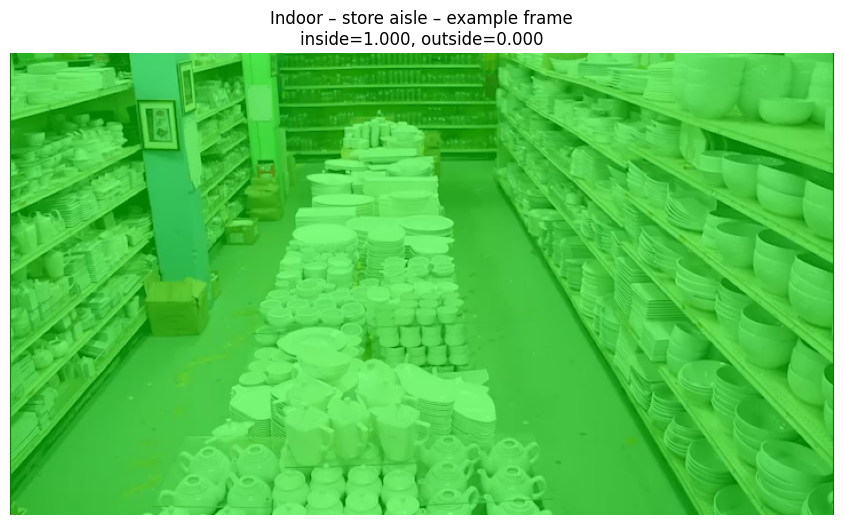

Inside-store pixel ratio: 1.000
Outside pixel ratio:     0.000
[Indoor – store aisle] Processed 3921/3921 frames
[Indoor – store aisle] Done! Segmented video saved to: /kaggle/working/segmented_store_aisle.mp4
Saved to: /kaggle/working/person_bicycle_car_detection.mp4
[Outdoor – street (person/bicycle/car)] 768x432 @ 12.00 FPS, 647 frames


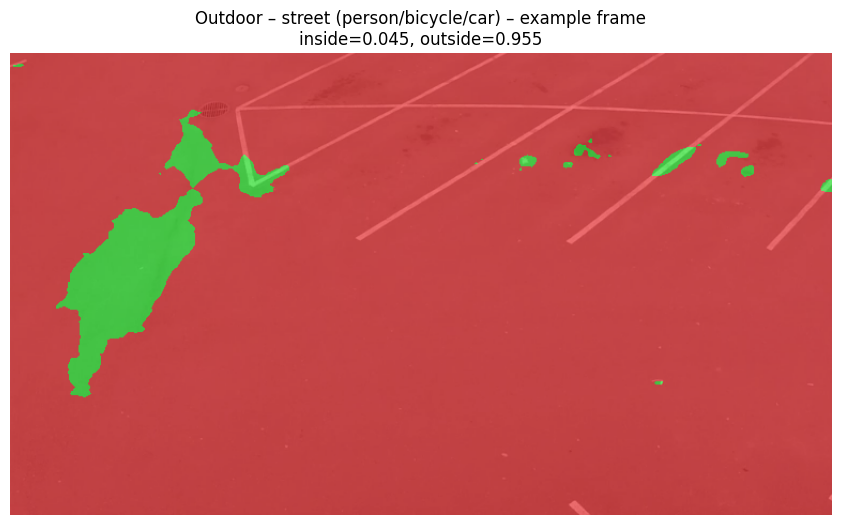

Inside-store pixel ratio: 0.045
Outside pixel ratio:     0.955
[Outdoor – street (person/bicycle/car)] Processed 647/647 frames
[Outdoor – street (person/bicycle/car)] Done! Segmented video saved to: /kaggle/working/segmented_street_outdoor.mp4

All done!
Indoor segmented video: /kaggle/working/segmented_store_aisle.mp4
Outdoor segmented video: /kaggle/working/segmented_street_outdoor.mp4


In [6]:
# --------------------------------------------------------------
# 9. Process TWO videos: indoor store + outdoor street
# --------------------------------------------------------------

# Indoor: store aisle video
INDOOR_URL = "https://github.com/intel-iot-devkit/sample-videos/raw/master/store-aisle-detection.mp4"
INDOOR_INPUT = "/kaggle/working/store_aisle_detection.mp4"
INDOOR_OUTPUT = "/kaggle/working/segmented_store_aisle.mp4"

# Outdoor: street with persons + bicycles + cars
OUTDOOR_URL = "https://github.com/intel-iot-devkit/sample-videos/raw/master/person-bicycle-car-detection.mp4"
OUTDOOR_INPUT = "/kaggle/working/person_bicycle_car_detection.mp4"
OUTDOOR_OUTPUT = "/kaggle/working/segmented_street_outdoor.mp4"

process_video(
    input_url=INDOOR_URL,
    input_path=INDOOR_INPUT,
    output_path=INDOOR_OUTPUT,
    title_prefix="Indoor – store aisle"
)

process_video(
    input_url=OUTDOOR_URL,
    input_path=OUTDOOR_INPUT,
    output_path=OUTDOOR_OUTPUT,
    title_prefix="Outdoor – street (person/bicycle/car)"
)

print("\nAll done!")
print("Indoor segmented video:", INDOOR_OUTPUT)
print("Outdoor segmented video:", OUTDOOR_OUTPUT)
